In [18]:
import os
import random
import tqdm
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(0)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

cuda = torch.cuda.is_available()
print('Using CUDA:',cuda)

ckp_folder = '/content/ckp'#! Define the folder to save weights in.
test_folder = '/content/test'#! Define the folder to save images at each epoch.

if not os.path.isdir(ckp_folder):
    os.makedirs(ckp_folder)

if not os.path.isdir(test_folder):
    os.makedirs(test_folder)

#! Define parameters here
latent_dim = 100
low_dim_rep = 8
decay_rate = 0.96
EPSILON = 0.00005

device = torch.device('cuda' if cuda else 'cpu')
assert device.type == 'cuda'

Using CUDA: True


In [2]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

### Data loading definitions

In [7]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/simpsons/cropped/8842.png  
  inflating: data/simpsons/cropped/8844.png  
  inflating: data/simpsons/cropped/8857.png  
  inflating: data/simpsons/cropped/8867.png  
  inflating: data/simpsons/cropped/887.png  
  inflating: data/simpsons/cropped/8893.png  
  inflating: data/simpsons/cropped/8897.png  
  inflating: data/simpsons/cropped/8918.png  
  inflating: data/simpsons/cropped/8921.png  
  inflating: data/simpsons/cropped/8945.png  
  inflating: data/simpsons/cropped/8956.png  
  inflating: data/simpsons/cropped/8959.png  
  inflating: data/simpsons/cropped/896.png  
  inflating: data/simpsons/cropped/8970.png  
  inflating: data/simpsons/cropped/8977.png  
  inflating: data/simpsons/cropped/8985.png  
  inflating: data/simpsons/cropped/9006.png  
  inflating: data/simpsons/cropped/9022.png  
  inflating: data/simpsons/cropped/9028.png  
  inflating: data/simpsons/cropped/9030.png  
  inflating: data/simpsons/crop

In [90]:
def get_data(size= 32):
    g = torch.Generator()
    g.manual_seed(0)
    train_data_dir = 'data/simpsons'

    train_tfms = transforms.Compose([transforms.Resize(128),
                                 transforms.RandomHorizontalFlip(0.5),transforms.ToTensor(),transforms.Normalize(0.5,0.5,0.5)
                                ]) #! Define the transformations here
    #将数据转换为Totensor，将图片normalization（-1,1)

    train_set = datasets.ImageFolder(os.path.join(train_data_dir), transform=train_tfms)#! Define the dataset here as a pytorchImageFolder w/ the above transforms.
    train_loader = DataLoader(train_set,batch_size = batch_size, shuffle= True, num_workers = 8, worker_init_fn=seed_worker, generator=g)

    return train_loader
batch_size=16
image_size=128*128
train_loader= get_data(image_size)
num_class = len(train_loader.dataset.classes)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  9888
number of batches:  618


In [91]:
train_loader= get_data(image_size)
num_class = len(train_loader.dataset.classes)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  9888
number of batches:  618


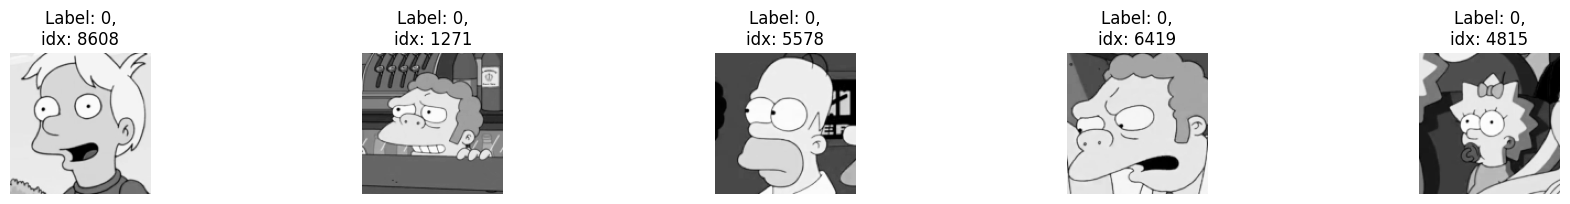

In [92]:

import random
def plot_gallery(imgs,image_size,num=5,class_idx=False):
    plt.figure(figsize=(20,6))
    for idx in range(num) :
        if class_idx:
            i = idx
        else:
            rand = random.randint(1,len(imgs))
            i = idx+rand
        img_ = imgs[i][0]
        label = imgs[i][1]
        plt.subplot(1, num, idx+1)
        plt.axis('off')
        plt.imshow(img_[1].reshape(img_.shape[2],img_.shape[1]),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,i))

plot_gallery(train_loader.dataset,image_size,class_idx=False)

### Defining the Discriminator

In [102]:
# we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.
#input:image
#output:0,1 使用sigmoid激活0-1
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            #layer1
            nn.Conv2d(3,64,kernel_size=5,stride=2,padding=1),#16,64,63,63
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            #layer2
            nn.Conv2d(64,128,kernel_size=5,stride=2,padding=1),#16, 128, 31, 31
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #layer3
            nn.Conv2d(128,256,kernel_size=5,stride=2,padding=1),#16, 256, 15, 15
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            #layer4
            nn.Conv2d(256,512,kernel_size=5,stride=1,padding=2),#16, 512, 15, 15
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #layer5
            nn.Conv2d(512,1024,kernel_size=5,stride=2,padding=2),#16, 1024, 8, 8
            nn.BatchNorm2d(1024)


         ) #! Define the discriminator layer here

        self.fc = nn.Sequential(
            nn.Linear(low_dim_rep*low_dim_rep*1024, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.dis(x)
        x = x.view(-1, low_dim_rep*low_dim_rep*1024)
        # x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

RuntimeError: ignored

In [100]:
test=Discriminator().to(device)
test=(torch.randn(1,100).to(device)).shape

RuntimeError: ignored

In [103]:
# criterion = F.binary_cross_entropy#! Define binary crossentory criterion
criterion =nn.BCEWithLogitsLoss()
optimizer_d =optim.Adam(discriminator.parameters(),lr=0.0001 ,betas=(0.5, 0.999))#! Define thediscriminator optimizer here

### Defining the Generator

In [23]:
def generate_latent_vector(size):
    z = torch.randn(size, latent_dim).to(device)
    return z
#输入的是一个长度为100的噪声（正态分布随机数）
#输出是图片

In [33]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, low_dim_rep*low_dim_rep*1024), # 100 is the length of our latent vector.
            nn.LeakyReLU(0.2)
        )

        self.gen = nn.Sequential(
            #layer1
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=1,output_padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #layer2
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2,output_padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            #layer3
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2,output_padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #layer4
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2,output_padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            #additional layer
            nn.Conv2d(64, 3, kernel_size=5, stride=1, padding=1),
            nn.Tanh()


         ) #! Defione the generator layers here

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 1024, low_dim_rep, low_dim_rep)
        x = self.gen(x)
        return x

torch.cuda.empty_cache()
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (gen): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyRe

In [27]:
optimizer_g = optim.Adam(discriminator.parameters(),lr=0.0001 ,betas=(0.5, 0.999))#! Define thediscriminator optimizer here

### Main training happens here

In [98]:
gen_loss=[]
dis_loss=[]
best_loss = np.inf
tolarance = 200
# torch.cuda.empty_cache()

num_epochs = 200

for ep in range(0,num_epochs):

    bformat='{l_bar}{bar}| {n_fmt}/{total_fmt} {rate_fmt}{postfix}'
    with tqdm.tqdm(total=len(train_loader),bar_format=bformat) as pbar:
        for n, (images, _) in enumerate(train_loader):
            images = images.to(device, dtype=torch.float)

            labels_fake = (((torch.rand(len(images))+1)/2)+0.2).to(device, dtype=torch.float) # labels  0.7 - 1.2
            labels_real = ((torch.rand(len(images)))/3).to(device, dtype=torch.float)  # labels  0 - 0.3
            rnd_indexes = list(set(np.random.randint(len(images), size=int(0.05*len(images)))))

            # flip the labels of 5% of the data for disciminator only
            for i in rnd_indexes:
                labels_real[i] = ((labels_real[i]+1)/2)+0.2
                labels_fake[i] = labels_fake[i]/3 - 0.1


            discriminator.zero_grad()
            #! Fwd pass for the discriminator
            loss_real = criterion(discriminator(images).squeeze(),labels_real) #! compute the loss between the discriminator output and `labels_real`
            #discriminator对真实图片的预测结果
            z = generate_latent_vector(len(images))#! Use generate_latent_vector to create a randon sample
            #! fwd passgenerator and subsequently discriminator(by detaching the tensor)
            images_fake = generator(z)
            outputs_fe = discriminator(images_fake.detach()).squeeze()#对生成的图片的预测m截断处理不会再传给判别器
            loss_fake = criterion(outputs_fe,labels_fake) #! Calculate the loss of generated images by using the output and `labels_fake`

            loss_d = loss_real+loss_fake#! combine losses
            #!run backwards and take step with `optimizer_d`
            loss_d.backward()
            optimizer_d.step()
            # Train the generator
            z = generate_latent_vector(len(images))
            images_fake = generator(z) #!fwd pass for the generator
            # Pass the genrated images to discriminator
            outputs_fe_gen = discriminator(images_fake) #! fwd pass for the discriminator w/ on output

            generator.zero_grad()

            labels_real = (torch.zeros(len(images))).to(device, dtype=torch.float)
            loss_g = criterion(outputs_fe_gen,labels_real)    #! Calculate the loss between outputs_fe_gen and labels_real
            #! Backpropagation
            loss_g.backward()
            optimizer_g.step()
            #! Update the weights by taking a step with the generator optimizer

            pbar.set_description(f"EPOCH: {ep:02d} ")
            pbar.set_postfix_str(f" LOSS D: {loss_d.item():.4f} | LOSS G:{loss_g.item():.4f} | LOSS REAL: {loss_real.item():.2f} | LOSS FAKE: {loss_fake.item():.4f}")
            pbar.update()

    print('\nD_loss: {}; G_loss: {}'.format(loss_d.item(), loss_g.item()))

    # Save the test results after each Epoch
    torch.save(generator.state_dict(), ckp_folder+'/model_gen_'+str(ep)+'.pth')
    torch.save(generator.state_dict(), ckp_folder+'/model_dis_'+str(ep)+'.pth')

    test_name = test_folder+'/ep'+str(ep)+'.png'

    test = generator(generate_latent_vector(len(images)))[0]
    save_image((test+ 1) / 2.0, test_name)

    dis_loss.append(loss_d.item())
    gen_loss.append(loss_g.item())


  0%|          | 0/618 ?it/s


RuntimeError: ignored

In [97]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

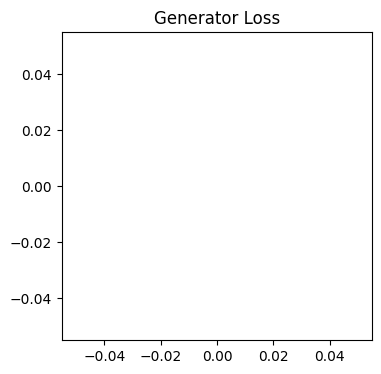

In [74]:
plt.figure(figsize=(4,4))
plt.title('Generator Loss')
plt.plot(gen_loss)
plt.show()

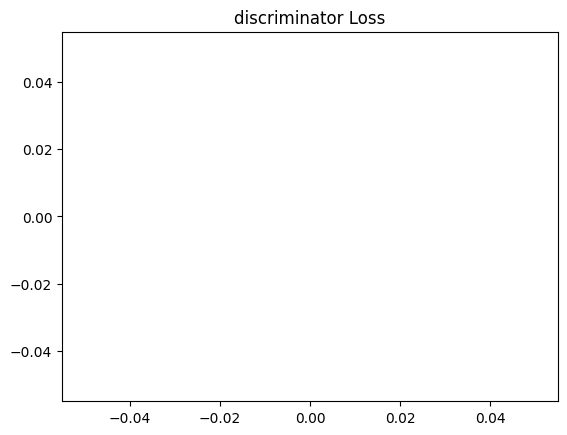

In [75]:
plt.title('discriminator Loss')
plt.plot(dis_loss)
plt.show()

In [76]:
minl=np.inf
for i,g in enumerate(gen_loss):
    if g<minl:
        minl=g
        minidx=i
minidx,minl

NameError: ignored